In [6]:
import pandas as pd
import psycopg2
from faker import Faker
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import uuid

# Generating fake data

In [7]:
# Initialize Faker
fake = Faker()

# Generate player data
players = [
    {'player_id': i, 
    'username': fake.user_name(), 
    'region': fake.country(), 
    'playtime': random.randint(10, 500), 
    'join_date': fake.date()
    } for i in range(1, 101)]
players_df = pd.DataFrame(players)

# Generate game data
games = [
    {'game_id': i, 
     'title': fake.catch_phrase(), 
     'genre': random.choice(['Action', 'RPG', 'Strategy', 'Sports']), 
     'developer': fake.company(), 
     'release_date': fake.date()
     } for i in range(1, 11)]
games_df = pd.DataFrame(games)

# Generate achievement data
achievements = [{
    'achievement_id': i, 
    'name': fake.word(), 
    'description': fake.sentence(), 
    'difficulty': random.choice(['Easy', 'Medium', 'Hard']), 
    'reward': random.randint(10, 100)
} for i in range(1, 51)]
achievements_df = pd.DataFrame(achievements)

# Generate time data
timestamps = [
    {'time_id': str(uuid.uuid4()),  # Generate a unique UUID
    'timestamp': datetime.now() - timedelta(days=random.randint(1, 365)),  # Random timestamp
    'hour': random.randint(0, 23),
    'day': random.randint(1, 31),
    'month': random.randint(1, 12),
    'year': random.randint(2020, 2023)
    } for _ in range(1000)]
time_df = pd.DataFrame(timestamps)

# Generate achievement fact data
achievement_facts = [{
    'player_id': random.randint(1, 100),
    'game_id': random.randint(1, 10),
    'achievement_id': random.randint(1, 50),
    'time_id': random.choice(timestamps)['time_id'],  # Use time_id instead of timestamp
    'completion_time': random.randint(60, 3600),
    'score_earned': random.randint(10, 100)
} for _ in range(1000)]
achievement_facts_df = pd.DataFrame(achievement_facts)

# Display sample data
print("Players Data:")
print(players_df.head())

print("\nGames Data:")
print(games_df.head())

print("\nAchievements Data:")
print(achievements_df.head())

print("\nTime Data:")
print(time_df.head())

print("\nAchievement Facts Data:")
print(achievement_facts_df.head())

Players Data:
   player_id        username        region  playtime   join_date
0          1  harriskathleen  Turkmenistan       382  1975-07-20
1          2    taylordalton     Singapore        60  2023-03-25
2          3  christinapratt        Cyprus        26  1994-03-15
3          4      walshkevin       Andorra       414  1971-05-12
4          5        angela00      Zimbabwe       160  2019-05-20

Games Data:
   game_id                                   title   genre  \
0        1              Extended composite success     RPG   
1        2            Versatile radical encryption  Sports   
2        3  Centralized non-volatile system engine  Sports   
3        4           Public-key explicit help-desk  Sports   
4        5           Organized even-keeled adapter  Sports   

                  developer release_date  
0  Maddox, Mendez and Lopez   2001-10-25  
1         Rodriguez-Stanley   1985-11-15  
2                Murphy PLC   2019-06-16  
3               Travis-Wall   1972-05-

# Table creation in database

In [13]:
# Connect to PostgreSQL
conn = psycopg2.connect(
    dbname="gaming_analytics",
    user="postgres",  # Replace with your username
    password="Amish@22",  # Replace with your password
    host="localhost"
)
cur = conn.cursor()

# Create tables
cur.execute("""
    CREATE TABLE IF NOT EXISTS player_dim (
        player_id SERIAL PRIMARY KEY,
        username VARCHAR(100),
        region VARCHAR(100),
        playtime INT,
        join_date DATE
    );
""")

cur.execute("""
    CREATE TABLE IF NOT EXISTS game_dim (
        game_id SERIAL PRIMARY KEY,
        title VARCHAR(100),
        genre VARCHAR(50),
        developer VARCHAR(100),
        release_date DATE
    );
""")

cur.execute("""
    CREATE TABLE IF NOT EXISTS achievement_dim (
        achievement_id SERIAL PRIMARY KEY,
        name VARCHAR(100),
        description TEXT,
        difficulty VARCHAR(50),
        reward INT
    );
""")

cur.execute("""
    CREATE TABLE IF NOT EXISTS time_dim (
        time_id UUID PRIMARY KEY DEFAULT gen_random_uuid(),  -- UUID as primary key
        timestamp TIMESTAMP,  -- Regular column for analysis
        hour INT,
        day INT,
        month INT,
        year INT
    );
""")

cur.execute("""
    CREATE TABLE IF NOT EXISTS achievement_fact (
        achievement_fact_id SERIAL PRIMARY KEY,
        player_id INT REFERENCES player_dim(player_id),
        game_id INT REFERENCES game_dim(game_id),
        achievement_id INT REFERENCES achievement_dim(achievement_id),
        time_id UUID REFERENCES time_dim(time_id),  -- Reference time_id instead of timestamp
        completion_time INT,
        score_earned INT
    );
""")

conn.commit()
print("Tables created successfully!")

Tables created successfully!


# Inserting generated data into each Tables

In [9]:
# Load player data
for _, row in players_df.iterrows():
    cur.execute("INSERT INTO player_dim (username, region, playtime, join_date) VALUES (%s, %s, %s, %s)",
                (row['username'], row['region'], row['playtime'], row['join_date']))
conn.commit()

# Load game data
for _, row in games_df.iterrows():
    cur.execute("INSERT INTO game_dim (title, genre, developer, release_date) VALUES (%s, %s, %s, %s)",
                (row['title'], row['genre'], row['developer'], row['release_date']))
conn.commit()

# Load achievement data
for _, row in achievements_df.iterrows():
    cur.execute("INSERT INTO achievement_dim (name, description, difficulty, reward) VALUES (%s, %s, %s, %s)",
                (row['name'], row['description'], row['difficulty'], row['reward']))
conn.commit()

# Load time data
for _, row in time_df.iterrows():
    cur.execute("""
        INSERT INTO time_dim (time_id, timestamp, hour, day, month, year)
        VALUES (%s, %s, %s, %s, %s, %s);
    """, (row['time_id'], row['timestamp'], row['hour'], row['day'], row['month'], row['year']))
conn.commit()

# Load achievement fact data
for _, row in achievement_facts_df.iterrows():
    cur.execute("""
        INSERT INTO achievement_fact (player_id, game_id, achievement_id, time_id, completion_time, score_earned)
        VALUES (%s, %s, %s, %s, %s, %s);
    """, (row['player_id'], row['game_id'], row['achievement_id'], row['time_id'], row['completion_time'], row['score_earned']))
conn.commit()

print("Data loaded into PostgreSQL!")

Data loaded into PostgreSQL!


# Query Check

In [20]:
# Query top players by total score
query = """
SELECT p.username, SUM(af.score_earned) AS total_score
FROM achievement_fact af
JOIN player_dim p ON af.player_id = p.player_id
GROUP BY p.username
ORDER BY total_score DESC
LIMIT 10;
"""
top_players_df = pd.read_sql(query, conn)
print("Top Players by Total Score:")
print(top_players_df)

Top Players by Total Score:
          username  total_score
0        payneryan          974
1            roy59          956
2  christinadaniel          920
3        deborah84          918
4           jose77          909
5         asimpson          889
6    martincrystal          878
7      simmonsalan          877
8   christinapratt          855
9          rgarcia          848


C:\Users\amish\AppData\Local\Temp\ipykernel_7236\53797143.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  top_players_df = pd.read_sql(query, conn)


# Ploting

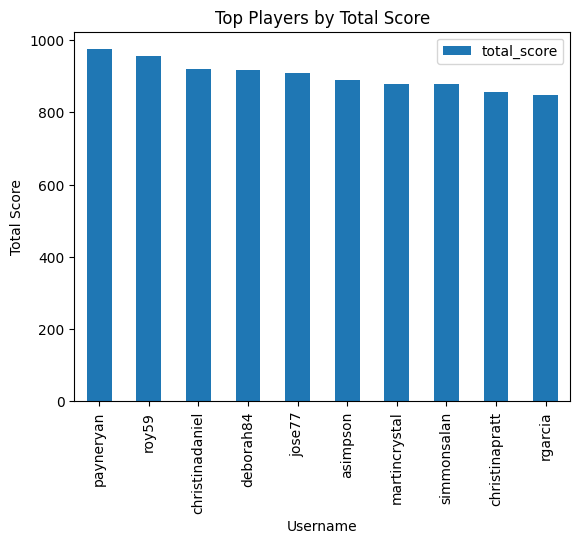

In [21]:
# Plot top players
top_players_df.plot(kind='bar', x='username', y='total_score', title='Top Players by Total Score')
plt.xlabel('Username')
plt.ylabel('Total Score')
plt.show()

In [12]:
# Close the connection
cur.close()
conn.close()
print("Connection closed.")

Connection closed.
